In [9]:
import os
import io
import pandas as pd
from google.cloud import storage
import ast
import matplotlib.pyplot as plt 
import warnings
import dask.dataframe as dd

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

key1 = os.getenv('GCP_KEY_1')
key2 = os.getenv('GCP_KEY_2')


client2 = storage.Client.from_service_account_json(key2)

#### 2023-04-30

In [ ]:
log1 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-04-30.parquet', engine='pyarrow')

In [ ]:
log1 = log1[log1.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
log1.head()

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-01T00:00:00.024Z,button,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...","{'description': '다음', 'location': 'signotherin...",96d1336f-744b-4deb-a6a4-207494419dbf,cfc34eab-6930-488b-8109-70d37cec7dae
1,2023-05-01T00:00:00.025Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,None,0.0,[],"{'language': 'ko-CA', 'isapp': 'true', 'osvers...","{'description': 'vote 선택', 'location': 'homevo...",2825d1b1-8325-42e2-88eb-8cae61d3a26d,0dde2ecb-ff03-440f-98f3-94f20978b796
2,2023-05-01T00:00:00.029Z,button,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...","{'description': '친구선택', 'location': 'homeenque...",335b0a36-9ecf-41a9-b7d2-e27125e521ef,b50774ed-24ce-49e1-9383-945ff3aea9ff
3,2023-05-01T00:00:00.036Z,button,QjToElcYNkVxszJDHBhqtITlzDJ3,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...","{'description': '이름 셔플!', 'location': 'homeenq...",b730bb6a-589a-4074-89a1-87f11a03f9d6,0999c6b6-c579-4c0f-916c-9a113010f84a
4,2023-05-01T00:00:00.063Z,button,VRpXf303RGU730fIO4EjWstzAJi1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...","{'description': '앱바 뒤로가기', 'location': 'homefr...",c2a5fd3f-92d5-4864-8e0e-63e563898499,45985493-ed35-4cc5-935f-1bcf922e213c


In [ ]:
log1_1 = log1[log1.index < 200000]

In [ ]:
log1_1['user_properties'] = log1_1['user_properties'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
log1_1_1 = log1_1.explode('user_properties')
log1_1_1['user_properties'].nunique()

0

In [ ]:
log1_1 = log1_1.drop(columns=['value','user_id','id','device_id','user_properties'])

In [3]:
def expand_dict_columns(df, dict_columns):
    df = df.copy()
    for col in dict_columns:
        # # 문자열인 dict 컬럼을 실제 dict로 변환
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

        # dict 컬럼을 여러 개의 컬럼으로 확장
        expanded = df[col].apply(pd.Series)

        # 컬럼 이름에 원래 컬럼명을 prefix로 추가
        expanded.columns = [f"{col}_{k}" for k in expanded.columns]

        # 원래 컬럼 제거하고 확장된 컬럼 병합
        df = pd.concat([df.drop(columns=[col]), expanded], axis=1)
    return df


In [ ]:
log1_2 = expand_dict_columns(log1_1, ['hackle_properties', 'event_properties'])

In [ ]:
log1_2 = log1_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor','hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel','hackle_properties_isapp'])

KeyError: "['hackle_properties_language', 'hackle_properties_osversion', 'hackle_properties_devicevendor', 'hackle_properties_osname', 'hackle_properties_versionname', 'hackle_properties_platform', 'hackle_properties_devicemodel'] not found in axis"

In [ ]:
log1_2

,Asia/Seoul,event_key,session_id,event_properties_description,event_properties_location,event_properties_sessionid
0,2023-05-01T00:00:00.024Z,button,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,다음,signotherinputscreen,None
1,2023-05-01T00:00:00.025Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,vote 선택,homevotesscreen,None
2,2023-05-01T00:00:00.029Z,button,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,친구선택,homeenquetescreen,None
3,2023-05-01T00:00:00.036Z,button,QjToElcYNkVxszJDHBhqtITlzDJ3,이름 셔플!,homeenquetescreen,None
4,2023-05-01T00:00:00.063Z,button,VRpXf303RGU730fIO4EjWstzAJi1,앱바 뒤로가기,homefriendprofilescreen,None
...,...,...,...,...,...,...
199995,2023-05-01T00:53:05.393Z,button,MbS10unFHUQlYtNE4v4yZGAaxSz2,내 실명은 ‘김예진' 맞아!,signotherinputscreen,None
199996,2023-05-01T00:53:05.423Z,button,AWaY7FMKtrcUxNlSf8i9ZRE12mv1,vote start,homeidlescreen,None
199997,2023-05-01T00:53:05.449Z,$session_start,f2pzw9aP0HMw9UiJdiW2HBjYKjk1,None,None,1682869985449.6f4d7b9c
199998,2023-05-01T00:53:05.480Z,button,qUdI3IvIlVUCCJyNLUTCNDGSdIx1,앱바 뒤로가기,homedetailscreen,None


In [ ]:
log1_2['event_key'].unique()

array(['button', '$session_end', '$session_start'], dtype=object)

In [ ]:
log1_2['event_properties_description'].unique()

array(['다음', 'vote 선택', '친구선택', '이름 셔플!', '앱바 뒤로가기', 'votes', None,
       '타임라인', '확인', '건너뛰기', '프로필', '친구+', '여자', '초성 힌트 받기', 'vote start',
       '학교 선택', '앱바 닫기', '친구 toggle', '친구 초대하고 바로 받기', '홈', '닫기', '홈으로',
       '사진첩에서 추가', '전체 이름 확인하기', '프로필 사진 수정', '계속하기', '칭찬 알림 받기', '학교',
       '동의하고 계속', 'title', '사진첩에서 불러오기', '인스타그램', '자동으로 친구추가', '문의하기',
       'feedback', "내 실명은 ‘홍유성' 맞아!", "내 실명은 ‘김주현' 맞아!", '내 학교 찾아보기',
       '친구 끊기', '취소', '다시 선택', "내 실명은 ‘박선우' 맞아!", 'about',
       "내 실명은 ‘김태은' 맞아!", '이미 가입했다면 로그인!', '설정으로 이동하기', '계정삭제',
       '연락처 불러오기', '로그아웃', '초기화하고 첫 화면으로', '초대링크 복사하기!',
       "내 실명은 ‘이수연' 맞아!", '아이디', '남자', '성별', '프로필 사진 삭제하기', '다시 입력하기',
       "내 실명은 ‘김효구' 맞아!", "내 실명은 ‘박혜원' 맞아!", '정말 떠날거니?', '함께 할 친구가 없어서',
       'vote 시작', "내 실명은 ‘최성율' 맞아!", '이름', '재밌는 질문이 없어서', '첫 화면 으로',
       '계정 삭제하기', '초대 링크 복사', "내 실명은 ‘김유건' 맞아!", "내 실명은 ‘최민석' 맞아!",
       "내 실명은 ‘고명선' 맞아!", "내 실명은 ‘서윤진' 맞아!", '정말로 로그아웃 할거야?',
       "내 실명은 ‘김서연' 맞아!", "내 실명은 ‘장승영' 맞아!", "내 

In [ ]:
log1_2[log1_2['session_id']=='ndyQc1KhirW2dMSGRscaXhV0NLx1']

,Asia/Seoul,event_key,session_id,event_properties_description,event_properties_location,event_properties_sessionid
9,2023-05-01T00:00:00.149Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,타임라인,homescreen,None
193,2023-05-01T00:00:02.978Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,votes,homescreen,None
295,2023-05-01T00:00:04.612Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,vote 선택,homevotesscreen,None
1133,2023-05-01T00:00:16.331Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homedetailscreen,None
18864,2023-05-01T00:04:13.105Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None
19881,2023-05-01T00:04:26.940Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None
20591,2023-05-01T00:04:36.373Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None
22576,2023-05-01T00:05:02.139Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None
23111,2023-05-01T00:05:09.304Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None
23719,2023-05-01T00:05:17.272Z,button,ndyQc1KhirW2dMSGRscaXhV0NLx1,앱바 뒤로가기,homefriendprofilescreen,None


In [ ]:
log1_2[log1_2['session_id']=='n3PI8GZnRFOKpJslIRgckMeRiln1'].head(60)

,Asia/Seoul,event_key,session_id,event_properties_description,event_properties_location,event_properties_sessionid
1,2023-05-01T00:00:00.025Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,vote 선택,homevotesscreen,None
79,2023-05-01T00:00:01.261Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,앱바 뒤로가기,homedetailscreen,None
135,2023-05-01T00:00:02.109Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,vote 선택,homevotesscreen,None
258,2023-05-01T00:00:03.926Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,앱바 뒤로가기,homedetailscreen,None
293,2023-05-01T00:00:04.589Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,vote 선택,homevotesscreen,None
454,2023-05-01T00:00:06.856Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,앱바 뒤로가기,homedetailscreen,None
534,2023-05-01T00:00:08.036Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,타임라인,homescreen,None
682,2023-05-01T00:00:10.085Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,친구+,homescreen,None
165618,2023-05-01T00:42:15.309Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,vote start,homeidlescreen,None
165839,2023-05-01T00:42:18.960Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,이름 셔플!,homeenquetescreen,None


##### 당일 유저가 많은 지

In [ ]:
log1.head()

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-01T00:00:00.024Z,button,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...","{'description': '다음', 'location': 'signotherin...",96d1336f-744b-4deb-a6a4-207494419dbf,cfc34eab-6930-488b-8109-70d37cec7dae
1,2023-05-01T00:00:00.025Z,button,n3PI8GZnRFOKpJslIRgckMeRiln1,None,0.0,[],"{'language': 'ko-CA', 'isapp': 'true', 'osvers...","{'description': 'vote 선택', 'location': 'homevo...",2825d1b1-8325-42e2-88eb-8cae61d3a26d,0dde2ecb-ff03-440f-98f3-94f20978b796
2,2023-05-01T00:00:00.029Z,button,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...","{'description': '친구선택', 'location': 'homeenque...",335b0a36-9ecf-41a9-b7d2-e27125e521ef,b50774ed-24ce-49e1-9383-945ff3aea9ff
3,2023-05-01T00:00:00.036Z,button,QjToElcYNkVxszJDHBhqtITlzDJ3,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...","{'description': '이름 셔플!', 'location': 'homeenq...",b730bb6a-589a-4074-89a1-87f11a03f9d6,0999c6b6-c579-4c0f-916c-9a113010f84a
4,2023-05-01T00:00:00.063Z,button,VRpXf303RGU730fIO4EjWstzAJi1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...","{'description': '앱바 뒤로가기', 'location': 'homefr...",c2a5fd3f-92d5-4864-8e0e-63e563898499,45985493-ed35-4cc5-935f-1bcf922e213c


In [ ]:
def day_1(df):
    df = df.drop(columns=['device_id','id','event_properties','hackle_properties','user_properties','value','user_id'])
    df = df.rename(columns={'Asia/Seoul':'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df_day= df.groupby(['session_id'])[['date']].value_counts().reset_index()
    df_day.loc[df_day['count']>=1,'is'] = 1
    df_day = df_day.groupby(['session_id'])[['is']].sum().reset_index()
    df_day.plot(kind='hist')

In [ ]:
day_1(log1)

#### 2023-05-06

In [ ]:
log2 = dd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-05-06.parquet', engine='pyarrow')

In [4]:
log2

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-05-07T00:00:00.014Z,$session_end,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683384973159.076d488c'},af49a3ac-cf10-49c9-a846-75c6350a331e,498dbc0f-4537-41dc-93ec-f4406302a3b0
1,2023-05-07T00:00:00.159Z,$session_end,CrFi87nvwiVvHExxP9uSfIHOmBy1,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683377977126.ecbb48be'},ea3608d7-51f7-417f-9560-484896fb265d,7770afa8-e228-4736-aa2a-658ebe2e3d25
2,2023-05-07T00:00:00.244Z,$session_end,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683385158861.10bc1ad8'},0d9da666-4047-4d40-a5ac-992876799cf4,9fbdc45d-a74a-4d9f-9d40-0f400b72877e
3,2023-05-07T00:00:00.255Z,$session_start,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683385200255.b26bcb8c'},947d1fff-5e4c-44e2-b106-f23cddbe0dc4,4efb4d45-0aaf-424a-8e4e-2f19249c8892
4,2023-05-07T00:00:00.316Z,$session_start,JdxVFvtz6AcxxOZVvl6plHayjYJ3,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683385200316.4c60e55a'},28e3afe4-098a-4bef-a699-4e3fa325b3ab,96348488-4d6a-49a8-8995-452718157fd7
...,...,...,...,...,...,...,...,...,...,...
7106583,2023-05-12T23:59:59.718Z,$session_end,uPxxXXZYFmMGCLZdNhtSine1cgG3,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683901438592.b17e8706'},f22b1603-2460-44c7-b7b2-b86a34b7d0fc,6a95d3bc-552a-4cf1-a080-c57b481097ae
7106584,2023-05-12T23:59:59.767Z,$session_end,VxISYEYmoLOi13a50CPbfU9bGWY2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683900321215.63cd03a9'},edc147d8-827e-4ec0-a50f-b6aa3af95247,5b225c86-adb5-4813-87e7-fb9bee753f31
7106585,2023-05-12T23:59:59.774Z,$session_end,fElOH2pD2xbMgPY39hVxmXD9lnd2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1683901254482.75e0403d'},bb3e735e-7ec5-479f-9b7c-4c87dae32ebe,88107386-2186-45b5-9edb-ec9f0b8f0283
7106586,2023-05-12T23:59:59.982Z,$session_end,suXh4zWRBIQgAu7r7qDVLRXFAag2,None,0.0,[],"{'language': 'ko', 'isapp': 'true', 'osversion...",{'sessionid': '1683898466941.22557276'},3a27db8e-39dd-46bd-ab83-06ea374e3a18,ef3d802d-e80d-4657-92ac-fe3b1a2ddb7e


In [ ]:
log2 = log2[log2.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
day_1(log2)

#### 2023-05-12

In [ ]:
log3 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-05-12.parquet', engine='pyarrow')

In [ ]:
log3 = log3[log3.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
day_1(log3)

#### 2023-05-18

In [ ]:
log4 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-05-18.parquet', engine='pyarrow')

In [ ]:
log4 = log4[log4.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
day_1(log4)

#### 2023-05-24

In [ ]:
log5 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-05-24.parquet', engine='pyarrow')

In [ ]:
log5 = log5[log5.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

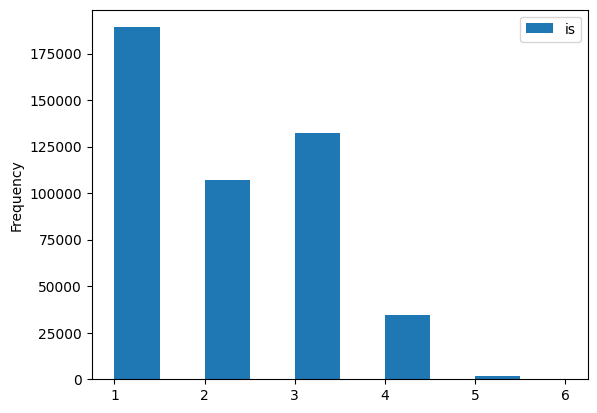

In [ ]:
day_1(log5)

In [ ]:
log5['event_key'].nunique()

1

In [ ]:
log5_1 = log5[log5.index < 200000]

In [ ]:
log5_1['user_properties'] = log5_1['user_properties'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
log5_1 = log5_1.drop(columns=['value','id','device_id','user_properties'])
log5_1

,Asia/Seoul,event_key,session_id,user_id,hackle_properties,event_properties
0,2023-05-25T00:00:00.219Z,$session_start,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400219.62ee4573'}
1,2023-05-25T00:00:00.224Z,$session_start,9tcpOeHvyldCUXMgRyFVQI86rf13,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400224.df939c47'}
2,2023-05-25T00:00:00.275Z,$session_start,aiDrtN8uHiQXRXmLMJhf27hKA4B3,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400275.457b984b'}
3,2023-05-25T00:00:00.369Z,$session_start,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400369.db2cd3ea'}
4,2023-05-25T00:00:00.493Z,$session_start,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684940400493.8e886f45'}
...,...,...,...,...,...,...
199995,2023-05-25T09:10:32.682Z,$session_start,a7rWG6CCv9QsM7RJYq4rkFz77Ss1,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684973432682.228da6a5'}
199996,2023-05-25T09:10:32.869Z,$session_start,zttLinV5jnhu6OzoyipzImtsjjB2,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684973432869.c19d3b39'}
199997,2023-05-25T09:10:33.037Z,$session_start,gu9TeaF0hWhTDga7QUQjqzaUYy82,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684973433037.a04ab327'}
199998,2023-05-25T09:10:33.048Z,$session_start,fUIFC8wJ6YaeK2kNhdEQs2ON1r22,None,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",{'sessionid': '1684973433048.465aa95d'}


In [ ]:
log5_2 = expand_dict_columns(log5_1, ['hackle_properties', 'event_properties'])

In [ ]:
log5_2

,Asia/Seoul,event_key,session_id,user_id,hackle_properties_language,hackle_properties_isapp,hackle_properties_osversion,hackle_properties_devicevendor,hackle_properties_versionname,hackle_properties_osname,hackle_properties_platform,hackle_properties_devicemodel,event_properties_sessionid
0,2023-05-25T00:00:00.219Z,$session_start,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,None,ko-KR,true,16.3,Apple,1.2.10,iOS,Mobile,"iPhone14,7",1684940400219.62ee4573
1,2023-05-25T00:00:00.224Z,$session_start,9tcpOeHvyldCUXMgRyFVQI86rf13,None,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone12,1",1684940400224.df939c47
2,2023-05-25T00:00:00.275Z,$session_start,aiDrtN8uHiQXRXmLMJhf27hKA4B3,None,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone12,1",1684940400275.457b984b
3,2023-05-25T00:00:00.369Z,$session_start,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,None,ko-KR,true,16.3.1,Apple,1.2.10,iOS,Mobile,"iPhone11,8",1684940400369.db2cd3ea
4,2023-05-25T00:00:00.493Z,$session_start,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,None,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone14,7",1684940400493.8e886f45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2023-05-25T09:10:32.682Z,$session_start,a7rWG6CCv9QsM7RJYq4rkFz77Ss1,None,ko-KR,true,15.7.5,Apple,1.2.10,iOS,Mobile,"iPhone9,3",1684973432682.228da6a5
199996,2023-05-25T09:10:32.869Z,$session_start,zttLinV5jnhu6OzoyipzImtsjjB2,None,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone12,1",1684973432869.c19d3b39
199997,2023-05-25T09:10:33.037Z,$session_start,gu9TeaF0hWhTDga7QUQjqzaUYy82,None,ko-KR,true,16.3.1,Apple,1.2.10,iOS,Mobile,"iPhone14,5",1684973433037.a04ab327
199998,2023-05-25T09:10:33.048Z,$session_start,fUIFC8wJ6YaeK2kNhdEQs2ON1r22,None,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone14,5",1684973433048.465aa95d


In [ ]:
log5_2 = log5_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor',\
    'hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel',\
        'hackle_properties_isapp'])

In [ ]:
log5_2

,Asia/Seoul,event_key,session_id,user_id,event_properties_sessionid
0,2023-05-25T00:00:00.219Z,$session_start,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,None,1684940400219.62ee4573
1,2023-05-25T00:00:00.224Z,$session_start,9tcpOeHvyldCUXMgRyFVQI86rf13,None,1684940400224.df939c47
2,2023-05-25T00:00:00.275Z,$session_start,aiDrtN8uHiQXRXmLMJhf27hKA4B3,None,1684940400275.457b984b
3,2023-05-25T00:00:00.369Z,$session_start,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,None,1684940400369.db2cd3ea
4,2023-05-25T00:00:00.493Z,$session_start,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,None,1684940400493.8e886f45
...,...,...,...,...,...
199995,2023-05-25T09:10:32.682Z,$session_start,a7rWG6CCv9QsM7RJYq4rkFz77Ss1,None,1684973432682.228da6a5
199996,2023-05-25T09:10:32.869Z,$session_start,zttLinV5jnhu6OzoyipzImtsjjB2,None,1684973432869.c19d3b39
199997,2023-05-25T09:10:33.037Z,$session_start,gu9TeaF0hWhTDga7QUQjqzaUYy82,None,1684973433037.a04ab327
199998,2023-05-25T09:10:33.048Z,$session_start,fUIFC8wJ6YaeK2kNhdEQs2ON1r22,None,1684973433048.465aa95d


#### 2023-06-17

In [ ]:
log6 = dd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-06-17.parquet', engine='pyarrow')

In [ ]:
log6 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-06-17.parquet', engine='pyarrow')

In [ ]:
log6 = log6.drop_duplicates(subset=['Asia/Seoul','event_key','session_id'])

In [ ]:
log6 = log6[log6.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

AttributeError: 'DataFrame' object has no attribute 'duplicated'

In [ ]:
log6.head()

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-06-18T00:07:08.014Z,$session_start,5cmi6ko54fPkNcJz6OftyN04nxL2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],1f3ac24a-d224-43d3-b2b7-a4d93329d5bc,8b6f9e35-473d-45d7-b8ad-884359609fdd
1,2023-06-18T00:07:11.039Z,$session_end,5cmi6ko54fPkNcJz6OftyN04nxL2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],9fdcd5e3-c9cf-4d40-821a-2a7ab78f4e74,8b6f9e35-473d-45d7-b8ad-884359609fdd
2,2023-06-18T00:07:34.065Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],94373dd4-7638-4b59-8b2c-fb1a62ebb3f0,4ff18855-0de6-4e51-a00c-7cdfe36bfc64
3,2023-06-18T01:01:12.503Z,$session_start,nn7Kppgo3HfNTFkqiDCJsP2aOVI2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e002e9b9-5cf6-4f0e-b470-f3a6277d42f6,99a6de2d-d222-46ff-81c2-729daff8e688
4,2023-06-18T02:30:47.469Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,None,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],e1df00c5-b260-4262-8352-7e4b732977a9,4ff18855-0de6-4e51-a00c-7cdfe36bfc64


In [ ]:
log6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4120154 entries, 0 to 4120153
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Asia/Seoul         object 
 1   event_key          object 
 2   session_id         object 
 3   user_id            object 
 4   value              float64
 5   user_properties    object 
 6   hackle_properties  object 
 7   event_properties   object 
 8   id                 object 
 9   device_id          object 
dtypes: float64(1), object(9)
memory usage: 314.3+ MB


In [ ]:
log6.shape

(4120154, 10)

In [ ]:
log6_1 = log6[log6.index < 500000]

In [ ]:
log6_1['user_properties'] = log6_1['user_properties'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
log6_1 = log6_1.drop(columns=['value','id','device_id','user_properties','user_id'])
log6_1

,Asia/Seoul,event_key,session_id,hackle_properties,event_properties
0,2023-06-18T00:07:08.014Z,$session_start,5cmi6ko54fPkNcJz6OftyN04nxL2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
1,2023-06-18T00:07:11.039Z,$session_end,5cmi6ko54fPkNcJz6OftyN04nxL2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
2,2023-06-18T00:07:34.065Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
3,2023-06-18T01:01:12.503Z,$session_start,nn7Kppgo3HfNTFkqiDCJsP2aOVI2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
4,2023-06-18T02:30:47.469Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
...,...,...,...,...,...
499995,2023-06-21T22:28:24.448Z,view_message_tap,242de5b0-6e2d-40aa-b533-c7bc9db0caef,"{'language': 'ko', 'isapp': 'true', 'osversion...",[]
499996,2023-06-21T22:28:24.468Z,click_notice_detail,175673eb-7657-4daf-8179-cef4470d78e7,"{'language': 'ko', 'isapp': 'true', 'osversion...","[(page_name, notice)]"
499997,2023-06-21T22:28:24.593Z,$session_end,fb4840b1-0739-4eca-8b63-b4a7772abb8f,"{'language': 'ko', 'isapp': 'true', 'osversion...",[]
499998,2023-06-21T22:28:24.606Z,view_timeline_tap,e3704569-685a-47c2-afda-739722a73072,"{'language': 'ko', 'isapp': 'true', 'osversion...",[]


In [ ]:
log6_2 = log6_1.drop(columns=['hackle_properties','event_properties'])

In [ ]:
log6_2 = expand_dict_columns(log6_1, ['hackle_properties', 'event_properties'])

In [ ]:
log6_2

,Asia/Seoul,event_key,session_id,hackle_properties_language,hackle_properties_isapp,hackle_properties_osversion,hackle_properties_devicevendor,hackle_properties_versionname,hackle_properties_osname,hackle_properties_platform,hackle_properties_devicemodel,event_properties_0
0,2023-06-18T00:07:08.014Z,$session_start,5cmi6ko54fPkNcJz6OftyN04nxL2,ko-KR,true,16.4.1,Apple,1.2.10,iOS,Mobile,"iPhone15,2",NaN
1,2023-06-18T00:07:11.039Z,$session_end,5cmi6ko54fPkNcJz6OftyN04nxL2,ko-KR,true,16.5,Apple,1.2.15,iOS,Mobile,"iPhone15,2",NaN
2,2023-06-18T00:07:34.065Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,ko-KR,true,15.7.3,Apple,1.2.8,iOS,Mobile,"iPhone8,4",NaN
3,2023-06-18T01:01:12.503Z,$session_start,nn7Kppgo3HfNTFkqiDCJsP2aOVI2,ko-KR,true,16.3.1,Apple,1.2.10,iOS,Mobile,"iPad13,1",NaN
4,2023-06-18T02:30:47.469Z,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2,ko-KR,true,15.7.3,Apple,1.2.8,iOS,Mobile,"iPhone8,4",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2023-06-21T09:57:11.762Z,view_message_tap,f7042063-bd63-4eaa-8347-47095ab58759,ko,true,9,samsung,1.2.15,Android,Mobile,SM-G950N,NaN
199996,2023-06-21T09:57:11.887Z,view_home_tap,e47237e5-4d80-447a-a36b-a1864583990a,ko,true,13,samsung,1.2.15,Android,Mobile,SM-G991N,NaN
199997,2023-06-21T09:57:12.261Z,$session_start,vBiRfuO1c1Xhb7qzw7rB1teLH9P2,ko,true,12,samsung,1.2.15,Android,Mobile,SM-G977N,NaN
199998,2023-06-21T09:57:12.261Z,launch_app,vBiRfuO1c1Xhb7qzw7rB1teLH9P2,ko,true,12,samsung,1.2.15,Android,Mobile,SM-G977N,NaN


In [ ]:
log6_2['event_properties_0'].unique().tolist()

[nan,
 ('$set', '{"heart_balance":"8158"}'),
 ('item_name', '무료충전소'),
 ('page_name', 'home'),
 ('$clearall', '{"clearall":"-"}'),
 ('page_name', 'notice'),
 ('page_name', 'profile'),
 ('$set', '{"heart_balance":"18816"}'),
 ('page_name', '학교선택'),
 ('$set', '{"heart_balance":"4580"}'),
 ('$set', '{"heart_balance":"781"}'),
 ('$set', '{"heart_balance":"137"}'),
 ('$set', '{"heart_balance":"2581"}'),
 ('$set', '{"heart_balance":"141"}'),
 ('page_name', 'invite'),
 ('page_name', '학년선택'),
 ('page_name', '반선택'),
 ('page_name', '연락처'),
 ('$set', '{"heart_balance":"701"}'),
 ('$set', '{"heart_balance":"170"}'),
 ('page_name', '번호입력'),
 ('$set', '{"heart_balance":"644"}'),
 ('$set', '{"heart_balance":"199"}'),
 ('$set', '{"heart_balance":"588"}'),
 ('$set', '{"heart_balance":"611"}'),
 ('$set', '{"friend_count":0}'),
 ('$set', '{"heart_balance":"1614"}'),
 ('$set', '{"heart_balance":"2662"}'),
 ('$set', '{"heart_balance":"9283"}'),
 ('$set', '{"heart_balance":"3448"}'),
 ('$set', '{"heart_balan

In [ ]:
log6_2 = log6_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor',\
    'hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel',\
        'hackle_properties_isapp'])

KeyError: "['hackle_properties_language', 'hackle_properties_osversion', 'hackle_properties_devicevendor', 'hackle_properties_osname', 'hackle_properties_versionname', 'hackle_properties_platform', 'hackle_properties_devicemodel', 'hackle_properties_isapp'] not found in axis"

In [ ]:
log6_2 = log6_2.rename(columns={'Asia/Seoul' : 'timestamp'})

In [ ]:
log6_2['timestamp'] = pd.to_datetime(log6_2['timestamp'])
df = log6_2.copy()

In [ ]:
log6_2['event_key'].unique()

array(['$session_start', '$session_end', 'launch_app', 'view_home_tap',
       'view_message_tap', 'view_timeline_tap', 'view_profile_tap',
       'view_questions_tap', 'view_friendplus_tap', 'view_shop',
       '$properties', 'click_purchase', 'click_notice',
       'click_question_ask', 'click_question_start',
       'view_question_question', 'click_question_open', 'view_login',
       'click_notice_detail', 'skip_question_question',
       'click_profile_ask', 'complete_question_question',
       'click_question_share', 'view_signup', 'click_friend_invite',
       'click_invite_friend', 'click_autoadd_contact'], dtype=object)

In [ ]:
df

,timestamp,event_key,session_id
0,2023-06-18 00:07:08.014000+00:00,$session_start,5cmi6ko54fPkNcJz6OftyN04nxL2
1,2023-06-18 00:07:11.039000+00:00,$session_end,5cmi6ko54fPkNcJz6OftyN04nxL2
2,2023-06-18 00:07:34.065000+00:00,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2
3,2023-06-18 01:01:12.503000+00:00,$session_start,nn7Kppgo3HfNTFkqiDCJsP2aOVI2
4,2023-06-18 02:30:47.469000+00:00,$session_start,WrOTpJzMF0fUed9MlXQggRmyXbw2
...,...,...,...
499995,2023-06-21 22:28:24.448000+00:00,view_message_tap,242de5b0-6e2d-40aa-b533-c7bc9db0caef
499996,2023-06-21 22:28:24.468000+00:00,click_notice_detail,175673eb-7657-4daf-8179-cef4470d78e7
499997,2023-06-21 22:28:24.593000+00:00,$session_end,fb4840b1-0739-4eca-8b63-b4a7772abb8f
499998,2023-06-21 22:28:24.606000+00:00,view_timeline_tap,e3704569-685a-47c2-afda-739722a73072


In [ ]:
# log6에 모든 행에 대해 분석할 때 @위험@ 시간 오래 걸림 
df = log6.copy()
df = df.drop(columns=['value','id','device_id','user_properties','user_id','hackle_properties','event_properties'])
df = df.rename(columns={'Asia/Seoul' : 'timestamp'})
df = df.compute()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
# 경로 분석
import pandas as pd
from collections import Counter


# 세션별 시간순 정렬
df_sorted = df.sort_values(by=['session_id', 'timestamp'])

# 세션별로 연속 이벤트 쌍 추출
transitions = []

for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_key'].tolist()
    transitions += list(zip(events[:-1], events[1:]))

# 전이 빈도 집계
transition_counts = Counter(transitions)

# 전체 전이 경로를 빈도수 기준으로 정렬 (내림차순)
sorted_transitions = sorted(transition_counts.items(), key=lambda x: x[1], reverse=True)

# 전체 출력
for (src, dst), count in sorted_transitions:
    print(f"{src} -> {dst}: {count}")


view_message_tap -> view_timeline_tap: 195416
view_home_tap -> view_questions_tap: 189414
$session_start -> view_home_tap: 178096
click_question_open -> view_home_tap: 169412
view_home_tap -> view_home_tap: 165516
view_home_tap -> view_message_tap: 162522
$session_end -> $session_start: 156303
launch_app -> $session_start: 145945
$session_start -> launch_app: 124668
click_question_ask -> view_home_tap: 123316
view_timeline_tap -> view_profile_tap: 119230
view_home_tap -> click_question_open: 119153
view_timeline_tap -> view_message_tap: 111836
skip_question_question -> skip_question_question: 102049
view_home_tap -> click_question_ask: 93154
view_questions_tap -> click_question_open: 90644
launch_app -> view_home_tap: 86746
view_questions_tap -> view_message_tap: 80269
click_question_start -> view_question_question: 76453
view_message_tap -> view_questions_tap: 76006
$session_end -> launch_app: 75980
view_questions_tap -> view_friendplus_tap: 74310
view_profile_tap -> view_timeline_tap

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict, Counter
import numpy as np

events = ['$session_start', '$session_end', 'launch_app', 'view_home_tap',
    'view_message_tap', 'view_timeline_tap', 'view_profile_tap',
    'view_questions_tap', 'view_friendplus_tap', 'view_shop',
    '$properties', 'click_purchase', 'click_notice',
    'click_question_ask', 'click_question_start',
    'view_question_question', 'click_question_open', 'view_login',
    'click_notice_detail', 'skip_question_question',
    'click_profile_ask', 'complete_question_question',
    'click_question_share', 'view_signup', 'click_friend_invite',
    'click_invite_friend', 'click_autoadd_contact']

    

def prepare_sankey_data(df, max_sequence_length=10):
    """
    사용자 세션별 이벤트 시퀀스를 생성하고 생키 차트용 데이터로 변환
    """
    # 세션별로 이벤트 시퀀스 생성
    session_sequences = {}
    
    for session_id in df['session_id'].unique():
        session_data = df[df['session_id'] == session_id].sort_values('timestamp')
        events = session_data['event_key'].tolist()
        
        # 너무 긴 시퀀스는 제한
        if len(events) > max_sequence_length:
            events = events[:max_sequence_length]
            
        session_sequences[session_id] = events
    
    # 이벤트 간 전환 횟수 계산
    transitions = defaultdict(int)
    
    for session_id, events in session_sequences.items():
        for i in range(len(events) - 1):
            source = events[i]
            target = events[i + 1]
            transitions[(source, target)] += 1
    
    return transitions

def create_sankey_chart(transitions, title="사용자 이벤트 플로우", min_flow=10):
    """
    생키 차트 생성
    """
    # 최소 플로우 이상인 전환만 필터링
    filtered_transitions = {k: v for k, v in transitions.items() if v >= min_flow}
    
    if not filtered_transitions:
        print(f"최소 플로우 {min_flow} 이상인 전환이 없습니다. min_flow 값을 낮춰주세요.")
        return None
    
    # 모든 이벤트 노드 수집
    all_events = set()
    for (source, target), count in filtered_transitions.items():
        all_events.add(source)
        all_events.add(target)
    
    # 노드 인덱스 매핑
    event_to_index = {event: i for i, event in enumerate(sorted(all_events))}
    
    # 생키 차트용 데이터 준비
    source_indices = []
    target_indices = []
    values = []
    
    for (source, target), count in filtered_transitions.items():
        source_indices.append(event_to_index[source])
        target_indices.append(event_to_index[target])
        values.append(count)
    
    # 노드 라벨과 색상
    labels = list(event_to_index.keys())
    
    # 이벤트 타입별 색상 설정
    def get_node_color(event):
        if event.startswith('$session'):
            return 'rgba(255, 99, 132, 0.8)'  # 세션 관련 - 빨간색
        elif event.startswith('view_'):
            return 'rgba(54, 162, 235, 0.8)'  # 뷰 관련 - 파란색
        elif event.startswith('click_'):
            return 'rgba(255, 206, 86, 0.8)'  # 클릭 관련 - 노란색
        elif event == 'launch_app':
            return 'rgba(75, 192, 192, 0.8)'  # 앱 실행 - 청록색
        else:
            return 'rgba(153, 102, 255, 0.8)'  # 기타 - 보라색
    
    node_colors = [get_node_color(event) for event in labels]
    
    # 생키 다이어그램 생성
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values,
            color='rgba(128, 128, 128, 0.4)'
        )
    )])
    
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=1200,
        height=800
    )
    
    return fig

def create_multiple_sankey_charts(df):
    """
    여러 종류의 생키 차트를 생성하여 다양한 관점에서 분석
    """
    print("다양한 생키 차트 생성 중...\n")
    
    # 1. 전체 이벤트 플로우 (매우 낮은 임계값)
    print("1. 전체 이벤트 플로우 차트 생성...")
    all_transitions = prepare_sankey_data(df, max_sequence_length=100)
    fig_all = create_sankey_chart(all_transitions, "전체 이벤트 플로우", min_flow=10)
    if fig_all:
        fig_all.show()
    
    # 2. 주요 이벤트 플로우 (중간 임계값)
    print("\n2. 주요 이벤트 플로우 차트 생성...")
    fig_main = create_sankey_chart(all_transitions, "주요 이벤트 플로우", min_flow=10)
    if fig_main:
        fig_main.show()
    
    # 3. 세션 시작/종료 중심 플로우
    print("\n3. 세션 시작/종료 중심 플로우 차트 생성...")
    session_events = ['$session_start', '$session_end', 'launch_app']
    session_df = df[df['event_key'].isin(session_events) | df['event_key'].str.startswith('view_')]
    session_transitions = prepare_sankey_data(session_df, max_sequence_length=100)
    fig_session = create_sankey_chart(session_transitions, "세션 & 뷰 이벤트 플로우", min_flow=10)
    if fig_session:
        fig_session.show()
    
    # 4. 사용자 액션 중심 플로우 (클릭 이벤트들)
    print("\n4. 사용자 액션 중심 플로우 차트 생성...")
    action_df = df[df['event_key'].str.startswith('click_') | df['event_key'].str.startswith('view_')]
    action_transitions = prepare_sankey_data(action_df, max_sequence_length=100)
    fig_action = create_sankey_chart(action_transitions, "사용자 액션 플로우 (클릭 & 뷰)", min_flow=10)
    if fig_action:
        fig_action.show()
    
    # 5. 핵심 사용자 여정 (가장 빈번한 경로만)
    print("\n5. 핵심 사용자 여정 차트 생성...")
    # 가장 빈번한 이벤트들만 선택
    top_events = df['event_key'].value_counts().index.tolist()
    core_df = df[df['event_key'].isin(top_events)]
    core_transitions = prepare_sankey_data(core_df, max_sequence_length=100)
    fig_core = create_sankey_chart(core_transitions, "핵심 사용자 여정 (TOP 10 이벤트)", min_flow=10)
    if fig_core:
        fig_core.show()
    
    return {
        'all': fig_all,
        'main': fig_main, 
        'session': fig_session,
        'action': fig_action,
        'core': fig_core
    }

def analyze_user_flow(df):
    """사용자 플로우 분석 및 인사이트 제공"""
    print("=== 사용자 이벤트 플로우 분석 ===\n")
    
    # 기본 통계
    print(f"총 이벤트 수: {len(df):,}")
    print(f"총 세션 수: {df['session_id'].nunique():,}")
    print(f"평균 세션당 이벤트 수: {len(df) / df['session_id'].nunique():.2f}")
    
    # 가장 빈번한 이벤트
    print("\n=== 가장 빈번한 이벤트 TOP 10 ===")
    event_counts = df['event_key'].value_counts()
    for i, (event, count) in enumerate(event_counts.items(), 1):
        print(f"{i:2d}. {event:<25} {count:,}회 ({count/len(df)*100:.1f}%)")
    
    return event_counts

# 메인 실행 부분
if __name__ == "__main__":

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # 2. 데이터 분석
    event_counts = analyze_user_flow(df)
    
    # 3. 생키 차트용 데이터 준비
    print("\n생키 차트 데이터 준비 중...")
    transitions = prepare_sankey_data(df, max_sequence_length=100)
    
    print(f"총 {len(transitions)}개의 이벤트 전환 패턴 발견")
    print("\n가장 빈번한 전환 패턴 TOP 10:")
    for i, ((source, target), count) in enumerate(sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:], 0):
        print(f"{i:2d}. {source} → {target}: {count}회")
    
    # 4. 생키 차트 생성
    print("\n생키 차트 생성 중...")
    fig = create_sankey_chart(transitions, min_flow=10)  # 최소 10회 이상 발생한 전환만 표시
    
    if fig:
        # 차트 표시
        fig.show()
        
        # HTML 파일로 저장
        fig.write_html("user_event_flow_sankey.html")
        print("생키 차트가 'user_event_flow_sankey.html' 파일로 저장되었습니다.")
    
    print("\n분석 완료!")

# 추가 유틸리티 함수들
def filter_events_by_type(df, event_types):
    """특정 이벤트 타입만 필터링"""
    return df[df['event_key'].isin(event_types)]

# def analyze_session_patterns(df):
#     """세션 패턴 분석"""
#     session_stats = df.groupby('session_id').agg({
#         'event_key': ['count', 'first', 'last'],
#         'timestamp': ['min', 'max']
#     }).round(2)
    
#     session_stats.columns = ['event_count', 'first_event', 'last_event', 'start_time', 'end_time']
#     session_stats['duration_minutes'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds() / 60
    
#     return session_stats

# 사용 예시:
# 특정 이벤트만 분석하고 싶을 때
# view_events = filter_events_by_type(df, ['view_home_tap', 'view_message_tap', 'view_timeline_tap'])
# view_transitions = prepare_sankey_data(view_events)
# view_fig = create_sankey_chart(view_transitions, min_flow=5)

=== 사용자 이벤트 플로우 분석 ===

총 이벤트 수: 4,119,970
총 세션 수: 145,182
평균 세션당 이벤트 수: 28.38

=== 가장 빈번한 이벤트 TOP 10 ===
 1. view_home_tap             990,242회 (24.0%)
 2. $session_start            427,577회 (10.4%)
 3. view_message_tap          371,978회 (9.0%)
 4. view_questions_tap        349,860회 (8.5%)
 5. launch_app                301,810회 (7.3%)
 6. view_timeline_tap         297,306회 (7.2%)
 7. $session_end              256,220회 (6.2%)
 8. click_question_open       210,543회 (5.1%)
 9. skip_question_question    140,275회 (3.4%)
10. view_profile_tap          133,186회 (3.2%)
11. click_question_ask        130,080회 (3.2%)
12. view_friendplus_tap       90,192회 (2.2%)
13. click_question_start      77,049회 (1.9%)
14. view_question_question    76,454회 (1.9%)
15. complete_question_question 54,722회 (1.3%)
16. click_notice              42,649회 (1.0%)
17. click_notice_detail       37,486회 (0.9%)
18. $properties               35,413회 (0.9%)
19. click_question_share      31,616회 (0.8%)
20. view_login           

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from datetime import datetime


# 타임스탬프를 datetime 형태로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 데이터 정렬 (시간순)
df = df.sort_values('timestamp').reset_index(drop=True)

print("=== 데이터 기본 정보 ===")
print(f"총 이벤트 수: {len(df)}")
print(f"고유 이벤트 종류: {df['event_key'].nunique()}")
print(f"고유 세션 수: {df['session_id'].nunique()}")
print()

# 1. 이벤트별 방문 빈도 분석
print("=== 1. 이벤트별 방문 빈도 ===")
event_counts = df['event_key'].value_counts()
print(event_counts)
print()

# 2. 이벤트 전환 분석 (세션별로)
print("=== 2. 이벤트 전환 패턴 분석 ===")

# 세션별로 이벤트 시퀀스 생성
session_sequences = {}
for session_id in df['session_id'].unique():
    session_data = df[df['session_id'] == session_id].sort_values('timestamp')
    session_sequences[session_id] = session_data['event_key'].tolist()

# 이벤트 전환 매트릭스 생성
transitions = defaultdict(int)
all_transitions = []

for session_id, events in session_sequences.items():
    for i in range(len(events) - 1):
        from_event = events[i]
        to_event = events[i + 1]
        transitions[(from_event, to_event)] += 1
        all_transitions.append((from_event, to_event))

# 전환 빈도 상위 10개
print("상위 전환 패턴:")
sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)
for (from_event, to_event), count in sorted_transitions[:]:
    print(f"{from_event} → {to_event}: {count}회")
print()

# 3. 고급 분석 결과
unique_events = df['event_key'].unique()
session_lengths = [len(events) for events in session_sequences.values()]
print("=== 3. 고급 분석 결과 ===")

# 가장 인기 있는 이벤트
most_popular_event = event_counts.idxmax()
print(f"가장 많이 발생한 이벤트: {most_popular_event} ({event_counts.max()}회)")

# 가장 흔한 전환 패턴
if sorted_transitions:
    most_common_transition = sorted_transitions[0]
    print(f"가장 흔한 전환 패턴: {most_common_transition[0][0]} → {most_common_transition[0][1]} ({most_common_transition[1]}회)")

# 세션 평균 길이
avg_session_length = np.mean(session_lengths)
print(f"평균 세션 길이: {avg_session_length:.2f} 이벤트")

# 각 이벤트의 전환율 분석
print("\n각 이벤트에서의 주요 전환:")
for event in unique_events:
    outgoing_transitions = [(to_event, count) for (from_event, to_event), count in transitions.items() if from_event == event]
    if outgoing_transitions:
        outgoing_transitions.sort(key=lambda x: x[1], reverse=True)
        total_outgoing = sum([count for _, count in outgoing_transitions])
        print(f"{event}:")
        for to_event, count in outgoing_transitions[:3]:  # 상위 3개만 표시
            percentage = (count / total_outgoing) * 100
            print(f"  → {to_event}: {count}회 ({percentage:.1f}%)")

# 5. 데이터 요약 함수
def analyze_user_journey(df):
    """사용자 여정 분석 함수"""
    results = {
        'total_events': len(df),
        'unique_events': df['event_key'].nunique(),
        'unique_sessions': df['session_id'].nunique(),
        'most_popular_event': df['event_key'].value_counts().idxmax(),
        'event_counts': df['event_key'].value_counts().to_dict(),
        'top_transitions': sorted_transitions[:5]
    }
    return results

# 분석 결과 출력
analysis_results = analyze_user_journey(df)
print(f"\n=== 분석 요약 ===")
print(f"총 이벤트: {analysis_results['total_events']}")
print(f"이벤트 종류: {analysis_results['unique_events']}")
print(f"세션 수: {analysis_results['unique_sessions']}")
print(f"가장 인기 이벤트: {analysis_results['most_popular_event']}")

=== 데이터 기본 정보 ===
총 이벤트 수: 4119970
고유 이벤트 종류: 28
고유 세션 수: 145182

=== 1. 이벤트별 방문 빈도 ===
event_key
view_home_tap                 990242
$session_start                427577
view_message_tap              371978
view_questions_tap            349860
launch_app                    301810
view_timeline_tap             297306
$session_end                  256220
click_question_open           210543
skip_question_question        140275
view_profile_tap              133186
click_question_ask            130080
view_friendplus_tap            90192
click_question_start           77049
view_question_question         76454
complete_question_question     54722
click_notice                   42649
click_notice_detail            37486
$properties                    35413
click_question_share           31616
view_login                     21969
view_signup                    21198
view_shop                      10721
click_purchase                  5223
click_profile_ask               4066
click_friend_i

In [ ]:
# message을 많이 이용했는지 어디서 어디로 전환되는지

import pandas as pd
from collections import defaultdict
from datetime import datetime


# 타임스탬프를 datetime 형태로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 데이터 정렬 (시간순)
df = df.sort_values('timestamp').reset_index(drop=True)

print("=== view_message_tap 전환 분석 ===")
print()

# 1. view_message_tap 총 발생 횟수
message_tap_count = len(df[df['event_key'] == 'view_message_tap'])
print(f"view_message_tap 총 발생 횟수: {message_tap_count}회")
print()

# 2. view_message_tap으로 전환된 케이스 분석
# 세션별로 이벤트 시퀀스 생성
session_sequences = {}
for session_id in df['session_id'].unique():
    session_data = df[df['session_id'] == session_id].sort_values('timestamp')
    session_sequences[session_id] = session_data[['event_key', 'timestamp']].values.tolist()

# view_message_tap으로의 전환 추적
transitions_to_message = defaultdict(int)
message_conversion_details = []

for session_id, events in session_sequences.items():
    for i in range(len(events)):
        if events[i][0] == 'view_message_tap':  # 현재 이벤트가 view_message_tap인 경우
            if i > 0:  # 이전 이벤트가 있는 경우
                prev_event = events[i-1][0]
                transitions_to_message[prev_event] += 1
                message_conversion_details.append({
                    'session_id': session_id,
                    'from_event': prev_event,
                    'to_event': 'view_message_tap',
                    'timestamp': events[i][1]
                })

print("=== view_message_tap으로의 전환 분석 ===")
if transitions_to_message:
    print("어떤 이벤트에서 view_message_tap으로 전환되었는지:")
    sorted_transitions = sorted(transitions_to_message.items(), key=lambda x: x[1], reverse=True)
    
    total_transitions = sum(transitions_to_message.values())
    print(f"총 view_message_tap 전환 횟수: {total_transitions}회")
    print()
    
    for from_event, count in sorted_transitions:
        percentage = (count / total_transitions) * 100
        print(f"{from_event} → view_message_tap: {count}회 ({percentage:.1f}%)")
else:
    print("view_message_tap으로의 전환이 발견되지 않았습니다.")

print()

# 3. view_message_tap에서 다른 이벤트로의 전환 분석
transitions_from_message = defaultdict(int)
message_exit_details = []

for session_id, events in session_sequences.items():
    for i in range(len(events) - 1):  # 마지막 이벤트는 제외 (다음 이벤트가 없으므로)
        if events[i][0] == 'view_message_tap':  # 현재 이벤트가 view_message_tap인 경우
            next_event = events[i+1][0]
            transitions_from_message[next_event] += 1
            message_exit_details.append({
                'session_id': session_id,
                'from_event': 'view_message_tap',
                'to_event': next_event,
                'timestamp': events[i+1][1]
            })

print("=== view_message_tap에서 다른 이벤트로의 전환 분석 ===")
if transitions_from_message:
    print("view_message_tap에서 어떤 이벤트로 전환되었는지:")
    sorted_exit_transitions = sorted(transitions_from_message.items(), key=lambda x: x[1], reverse=True)
    
    total_exit_transitions = sum(transitions_from_message.values())
    print(f"총 view_message_tap에서의 전환 횟수: {total_exit_transitions}회")
    print()
    
    for to_event, count in sorted_exit_transitions:
        percentage = (count / total_exit_transitions) * 100
        print(f"view_message_tap → {to_event}: {count}회 ({percentage:.1f}%)")
else:
    print("view_message_tap에서 다른 이벤트로의 전환이 발견되지 않았습니다.")

print()

# 4. 상세 전환 정보
# print("=== 상세 전환 정보 ===")
# if message_conversion_details:
#     print("view_message_tap으로의 전환 상세:")
#     for detail in message_conversion_details:
#         print(f"세션 {detail['session_id']}: {detail['from_event']} → {detail['to_event']} at {detail['timestamp']}")
#     print()

# if message_exit_details:
#     print("view_message_tap에서의 전환 상세:")
#     for detail in message_exit_details:
#         print(f"세션 {detail['session_id']}: {detail['from_event']} → {detail['to_event']} at {detail['timestamp']}")

# 5. 요약 함수
def analyze_message_tap_conversions(df):
    """view_message_tap 전환 분석 요약 함수"""
    
    # 기본 통계
    total_message_taps = len(df[df['event_key'] == 'view_message_tap'])
    total_events = len(df)
    message_tap_ratio = (total_message_taps / total_events) * 100 if total_events > 0 else 0
    
    # 세션별 분석
    sessions_with_message = df[df['event_key'] == 'view_message_tap']['session_id'].nunique()
    total_sessions = df['session_id'].nunique()
    session_conversion_rate = (sessions_with_message / total_sessions) * 100 if total_sessions > 0 else 0
    
    return {
        'total_message_taps': total_message_taps,
        'message_tap_ratio': message_tap_ratio,
        'sessions_with_message': sessions_with_message,
        'total_sessions': total_sessions,
        'session_conversion_rate': session_conversion_rate,
        'transitions_to_message': dict(transitions_to_message),
        'transitions_from_message': dict(transitions_from_message)
    }

# 분석 결과 요약
summary = analyze_message_tap_conversions(df)
print("\n=== 요약 ===")
print(f"전체 이벤트 중 view_message_tap 비율: {summary['message_tap_ratio']:.1f}%")
print(f"view_message_tap이 발생한 세션 수: {summary['sessions_with_message']}/{summary['total_sessions']} ({summary['session_conversion_rate']:.1f}%)")
print(f"view_message_tap으로 전환한 총 횟수: {sum(transitions_to_message.values())}회")
print(f"view_message_tap에서 다른 이벤트로 전환한 총 횟수: {sum(transitions_from_message.values())}회")

=== view_timeline_tap 전환 분석 ===

view_timeline_tap 총 발생 횟수: 38617회

=== view_timeline_tap으로의 전환 분석 ===
어떤 이벤트에서 view_timeline_tap으로 전환되었는지:
총 view_timeline_tap 전환 횟수: 38617회

view_message_tap → view_timeline_tap: 24929회 (64.6%)
view_profile_tap → view_timeline_tap: 9255회 (24.0%)
view_home_tap → view_timeline_tap: 4327회 (11.2%)
$session_start → view_timeline_tap: 89회 (0.2%)
$session_end → view_timeline_tap: 15회 (0.0%)
view_questions_tap → view_timeline_tap: 2회 (0.0%)

=== view_timeline_tap에서 다른 이벤트로의 전환 분석 ===
view_timeline_tap에서 어떤 이벤트로 전환되었는지:
총 view_timeline_tap에서의 전환 횟수: 37573회

view_timeline_tap → view_message_tap: 16068회 (42.8%)
view_timeline_tap → view_profile_tap: 15001회 (39.9%)
view_timeline_tap → view_home_tap: 4220회 (11.2%)
view_timeline_tap → $session_start: 920회 (2.4%)
view_timeline_tap → $session_end: 646회 (1.7%)
view_timeline_tap → launch_app: 497회 (1.3%)
view_timeline_tap → view_questions_tap: 201회 (0.5%)
view_timeline_tap → click_profile_ask: 9회 (0.0%)
view_timeline_tap

In [ ]:
log6_2['Hour'] = log6_2['timestamp'].dt.hour

In [ ]:
grp = log6_2.groupby('Hour')['session_id'].count()

<Axes: xlabel='Hour'>

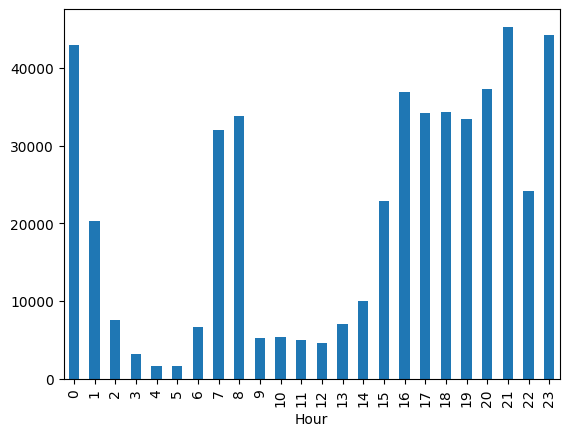

In [ ]:
grp.plot(kind='bar', x= 'Hour',y= 'session_id')

#### 2023-06-23

In [ ]:
log7 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-06-23.parquet', engine='pyarrow')

In [ ]:
log7 = log7['session_id']

In [ ]:
log6 = log6['session_id']

In [ ]:
log7 = log7[log7.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
log7_1 = log7[log7.index < 200000]

In [ ]:
log7_1['user_properties'] = log7_1['user_properties'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
log7_1 = log7_1.drop(columns=['value','id','device_id','user_properties'])
log7_1

,Asia/Seoul,event_key,session_id,user_id,hackle_properties,event_properties
0,2023-06-24T00:00:00.023Z,view_question_question,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,mNLDRM56CjeiREW9NH8dHObLiTM2,"{'language': 'ko', 'isapp': 'true', 'osversion...",[]
1,2023-06-24T00:00:00.064Z,view_timeline_tap,XjKd6fh3CCfKJxobCxGssTIcoCp1,XjKd6fh3CCfKJxobCxGssTIcoCp1,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
2,2023-06-24T00:00:00.148Z,view_message_tap,QepNLzWEkTNvfHSSkhCldJH5eMw2,QepNLzWEkTNvfHSSkhCldJH5eMw2,"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[]
3,2023-06-24T00:00:00.169Z,$session_start,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[]
4,2023-06-24T00:00:00.174Z,view_home_tap,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,"{'language': 'ko-US', 'isapp': 'true', 'osvers...",[]
...,...,...,...,...,...,...
199995,2023-06-24T02:20:41.801Z,view_questions_tap,zRzQhNicWNbSxAu2vaZyXdqaOJs1,zRzQhNicWNbSxAu2vaZyXdqaOJs1,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
199996,2023-06-24T02:20:41.813Z,view_message_tap,nGZLI1Tyx7eTKw0pns1fFBgUSwE2,nGZLI1Tyx7eTKw0pns1fFBgUSwE2,"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[]
199997,2023-06-24T02:20:41.869Z,view_timeline_tap,PPR40KJh3heo4s6SeWMUF6fTet12,PPR40KJh3heo4s6SeWMUF6fTet12,"{'language': 'en-KR', 'isapp': 'true', 'osvers...",[]
199998,2023-06-24T02:20:41.895Z,view_profile_tap,6cc44d83-e103-48e2-9cac-cf2ac174d9a7,umSamYN0L6YAAnnMPOOqPFTT2lE3,"{'language': 'ko', 'isapp': 'true', 'osversion...",[]


In [ ]:
log7_2 = expand_dict_columns(log7_1, ['hackle_properties', 'event_properties'])

In [ ]:
log7_2 = log7_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor',\
    'hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel',\
        'hackle_properties_isapp'])

In [ ]:
log7_2

,Asia/Seoul,event_key,session_id,user_id,event_properties_0
0,2023-06-24T00:00:00.023Z,view_question_question,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,mNLDRM56CjeiREW9NH8dHObLiTM2,NaN
1,2023-06-24T00:00:00.064Z,view_timeline_tap,XjKd6fh3CCfKJxobCxGssTIcoCp1,XjKd6fh3CCfKJxobCxGssTIcoCp1,NaN
2,2023-06-24T00:00:00.148Z,view_message_tap,QepNLzWEkTNvfHSSkhCldJH5eMw2,QepNLzWEkTNvfHSSkhCldJH5eMw2,NaN
3,2023-06-24T00:00:00.169Z,$session_start,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,NaN
4,2023-06-24T00:00:00.174Z,view_home_tap,C03B343F-B566-46BA-9030-8E441B71EC33,WVcHhMtN5uVbI9ZW7OM3iMWeXMl1,NaN
...,...,...,...,...,...
199995,2023-06-24T02:20:41.801Z,view_questions_tap,zRzQhNicWNbSxAu2vaZyXdqaOJs1,zRzQhNicWNbSxAu2vaZyXdqaOJs1,NaN
199996,2023-06-24T02:20:41.813Z,view_message_tap,nGZLI1Tyx7eTKw0pns1fFBgUSwE2,nGZLI1Tyx7eTKw0pns1fFBgUSwE2,NaN
199997,2023-06-24T02:20:41.869Z,view_timeline_tap,PPR40KJh3heo4s6SeWMUF6fTet12,PPR40KJh3heo4s6SeWMUF6fTet12,NaN
199998,2023-06-24T02:20:41.895Z,view_profile_tap,6cc44d83-e103-48e2-9cac-cf2ac174d9a7,umSamYN0L6YAAnnMPOOqPFTT2lE3,NaN


#### 2023-06-29

In [ ]:
log8 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-06-29.parquet', engine='pyarrow')

In [ ]:
log8 = log8[log8.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
log8_1 = log8[log8.index < 200000]

In [ ]:
log8_1['user_properties'] = log9log8_1_1['user_properties'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
log8_1 = log8_1.drop(columns=['value','id','device_id','user_properties'])
log8_1

In [ ]:
log8_2 = expand_dict_columns(log8_1, ['hackle_properties', 'event_properties'])

In [ ]:
log8_2 = log8_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor',\
    'hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel',\
        'hackle_properties_isapp'])

In [ ]:
log8_2

#### 2023-07-05

In [ ]:
log9 = pd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-07-05.parquet', engine='pyarrow')

In [ ]:
log9.head()

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-07-06T00:00:00.234Z,view_home_tap,GCZf2jHnnpSHH7DnviWmLLiG20j1,GCZf2jHnnpSHH7DnviWmLLiG20j1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f0c6f1b5-2c63-4944-9755-f70f8c116829,19d76555-5bf6-4f86-9d79-e71b4f1e3589
1,2023-07-06T00:00:00.285Z,$session_start,8PZ7GgUaVXSAGn3lPv2E51lfeir1,8PZ7GgUaVXSAGn3lPv2E51lfeir1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f76c51fd-1784-4161-bc9f-8ec621117179,37ba7f82-917f-464d-bfd8-2a83c4aef701
2,2023-07-06T00:00:00.372Z,view_profile_tap,ZeH6snQ1gxWQfRodLFDV6qMMcmG2,ZeH6snQ1gxWQfRodLFDV6qMMcmG2,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],07a10746-b0cf-465d-9326-ba43ea02721c,3fe79d88-9d5c-43ff-b7ae-513855f9e97f
3,2023-07-06T00:00:00.397Z,launch_app,8PZ7GgUaVXSAGn3lPv2E51lfeir1,8PZ7GgUaVXSAGn3lPv2E51lfeir1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],6e09b3a6-690b-4204-a8aa-91fb71b68863,37ba7f82-917f-464d-bfd8-2a83c4aef701
4,2023-07-06T00:00:00.473Z,$session_start,raovhvckyKM8m1X2hKrIja8yIb92,raovhvckyKM8m1X2hKrIja8yIb92,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],37d76708-46b3-46eb-a6a3-3c29d68bb8ca,25cf1eb3-65b8-418b-b99b-db2f87ef647a


In [ ]:
log9 = log9[log9.duplicated(subset=['Asia/Seoul','event_key','session_id'])==False]

In [ ]:
log9 = log9[log9.index < 200000]

In [ ]:
log9_1 = log9.drop(columns=['value','id','device_id'])

In [ ]:
log9_2 = log9_1.drop(columns=['hackle_properties', 'event_properties','user_properties'])

In [ ]:
log9_2 = expand_dict_columns(log9_1, ['hackle_properties', 'event_properties','user_properties'])

In [ ]:
log9_2 = log9_2.drop(columns=['hackle_properties_language','hackle_properties_osversion','hackle_properties_devicevendor',\
    'hackle_properties_osname','hackle_properties_versionname','hackle_properties_platform','hackle_properties_devicemodel',\
        'hackle_properties_isapp'])

In [ ]:
log9_2[log9_2.duplicated(subset=['session_id','user_id'])]

,Asia/Seoul,event_key,session_id,user_id
3,2023-07-06T00:00:00.397Z,launch_app,8PZ7GgUaVXSAGn3lPv2E51lfeir1,8PZ7GgUaVXSAGn3lPv2E51lfeir1
5,2023-07-06T00:00:00.473Z,launch_app,raovhvckyKM8m1X2hKrIja8yIb92,raovhvckyKM8m1X2hKrIja8yIb92
7,2023-07-06T00:00:00.517Z,$session_start,r20UNOLo5VSAALMH3KMIis9wEn33,r20UNOLo5VSAALMH3KMIis9wEn33
8,2023-07-06T00:00:00.517Z,launch_app,r20UNOLo5VSAALMH3KMIis9wEn33,r20UNOLo5VSAALMH3KMIis9wEn33
17,2023-07-06T00:00:01.238Z,launch_app,VCb7S8tZ9KQdrmAeCriYmsqswr83,VCb7S8tZ9KQdrmAeCriYmsqswr83
...,...,...,...,...
199994,2023-07-06T16:04:56.652Z,click_question_start,CiNafp7sqxWQHTcU3Y3lMCOLQ9C3,CiNafp7sqxWQHTcU3Y3lMCOLQ9C3
199995,2023-07-06T16:04:56.915Z,view_questions_tap,PAGHJwNS06aIMEXr6tlj3xBhgiE3,PAGHJwNS06aIMEXr6tlj3xBhgiE3
199996,2023-07-06T16:04:56.934Z,view_question_question,CiNafp7sqxWQHTcU3Y3lMCOLQ9C3,CiNafp7sqxWQHTcU3Y3lMCOLQ9C3
199998,2023-07-06T16:04:57.237Z,view_message_tap,n0zc9eovgIRO1165GpowWahNKIZ2,n0zc9eovgIRO1165GpowWahNKIZ2


In [ ]:
log9.shape

(2878668, 10)

In [ ]:
log9[log9.duplicated(subset=['session_id','user_id'])].shape

(2681391, 10)

In [ ]:
log9.head(1)

,Asia/Seoul,event_key,session_id,user_id,value,user_properties,hackle_properties,event_properties,id,device_id
0,2023-07-06T00:00:00.234Z,view_home_tap,GCZf2jHnnpSHH7DnviWmLLiG20j1,GCZf2jHnnpSHH7DnviWmLLiG20j1,0.0,[],"{'language': 'ko-KR', 'isapp': 'true', 'osvers...",[],f0c6f1b5-2c63-4944-9755-f70f8c116829,19d76555-5bf6-4f86-9d79-e71b4f1e3589


In [ ]:
log9.groupby(['event_key'])[['id']].count().sort_values(by='id',ascending=False).reset_index()

,event_key,id
0,view_home_tap,572319
1,$session_start,344292
2,launch_app,311920
3,$session_end,221432
4,click_question_open,183009
5,view_questions_tap,157063
6,view_message_tap,140106
7,skip_question_question,131762
8,view_timeline_tap,112446
9,$properties,66976


#### log 분석

In [6]:
import os
import io
import pandas as pd
from google.cloud import storage
import ast
import matplotlib.pyplot as plt 
import warnings
import dask.dataframe as dd

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

key1 = os.getenv('GCP_KEY_1')
key2 = os.getenv('GCP_KEY_2')



In [11]:
hackle = dd.read_parquet('gs://sprintda05_final_project/final/FINAL_HACKLE.parquet', engine='pyarrow', storage_options={'token': key1})

In [ ]:
hackle.head()

,event_key,session_id,device_id,user_id,asia_seoul,event_datetime
0,$session_start,1b139b39-febb-4c08-a630-16ee3b640815,b'\x1b\x13\x9b9\xfe\xbbL\x08\xa60\x16\xee;d\x0...,<NA>,2023-04-01T00:00:40.413Z,NaT
1,button_내 학교 찾아보기,1b139b39-febb-4c08-a630-16ee3b640815,b'\x1b\x13\x9b9\xfe\xbbL\x08\xa60\x16\xee;d\x0...,<NA>,2023-04-01T00:00:41.234Z,NaT
2,$session_start,08a0293d-f6c0-4900-901e-436a503da924,b'\x08\xa0)=\xf6\xc0I\x00\x90\x1eCjP=\xa9$',<NA>,2023-04-01T00:00:53.630Z,NaT
3,button_앱바 뒤로가기,1b139b39-febb-4c08-a630-16ee3b640815,b'\x1b\x13\x9b9\xfe\xbbL\x08\xa60\x16\xee;d\x0...,<NA>,2023-04-01T00:00:53.966Z,NaT
4,button_내 학교 찾아보기,08a0293d-f6c0-4900-901e-436a503da924,b'\x08\xa0)=\xf6\xc0I\x00\x90\x1eCjP=\xa9$',<NA>,2023-04-01T00:00:54.520Z,NaT


In [14]:
hackle.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_key       5 non-null      string        
 1   session_id      5 non-null      string        
 2   device_id       5 non-null      object        
 3   user_id         0 non-null      string        
 4   asia_seoul      5 non-null      string        
 5   event_datetime  0 non-null      datetime64[us]
dtypes: datetime64[us](1), object(1), string(4)
memory usage: 707.0+ bytes


#### duckDB

In [1]:
import dask.dataframe as dd
import duckdb

In [11]:
log9 = dd.read_parquet('gs://sprint_final_project/final_project/hackle_log/2023-07-05.parquet', engine='pyarrow', storage_options={'token': key2})

In [4]:
con = duckdb.connect()

In [6]:
df=  con.execute("SELECT * FROM log9", { 'log9' : log9 }).fetchdf()

NotImplementedException: Not implemented Error: Unable to transform python value of type '<class 'dask.dataframe.dask_expr._collection.DataFrame'>' to DuckDB LogicalType

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(token='/home/jovyan/work/secrets/sprint-mission18-32fb7d8f5e4e.json')

# GCS에서 로컬로 다운로드
# fs.get('sprint_final_project/final_project/hackle_log/2023-07-05.parquet', 'local_file.parquet')

In [ ]:
# DuckDB에서 로컬 파일 분석
con = duckdb.connect()
df = con.execute("SELECT * FROM 'local_file.parquet'").fetchdf()

In [ ]:
con.execute("SELECT * FROM df")